In [1]:
import csv
import cv2
import numpy as np
import os
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.layers.advanced_activations import ELU
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Cropping2D
from keras.layers import Activation, Dropout, MaxPooling2D, Lambda
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'retina'
from keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


In [2]:
img_path = './IMG/'
csv_path = './driving_log.csv'

image_paths = []
angles = []

In [3]:

with open('./driving_log.csv', newline = '') as csvfile:
    driving_data = list(csv.reader(csvfile, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
 
    for row in driving_data[1:]:
        if float(row[6]) < 0.1:
            continue
        image_paths.append(img_path + row[0].split('/')[-1])
        angles.append(float(row[3]))
        image_paths.append(img_path + row[1].split('/')[-1])
        angles.append(float(row[3]) + 0.25)
        image_paths.append(img_path + row[2].split('/')[-1])
        angles.append(float(row[3]) - 0.25)
    
image_paths = np.array(image_paths)
angles = np.array(angles)

In [4]:
print( image_paths.shape, angles.shape)

(39672,) (39672,)


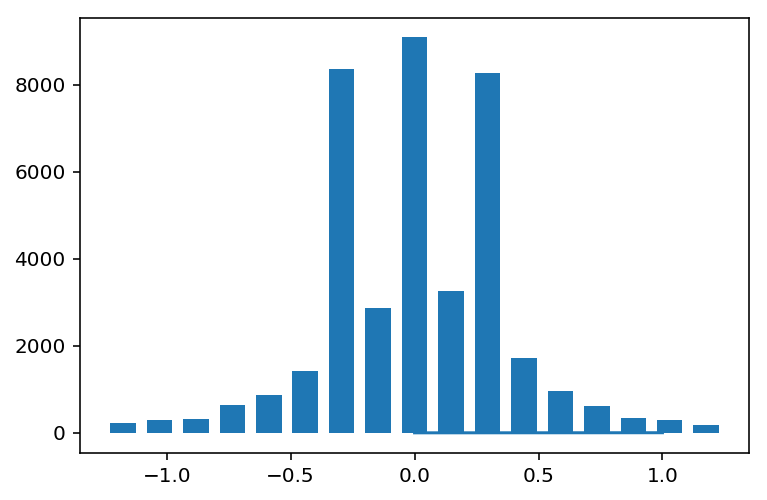

In [9]:
num_bins = 17
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)))

In [10]:
def brighten(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # convert from RGB to HSV color
    brightness_random =  .23 + np.random.uniform() # random brightness 
    image[:,:,2] = image[:,:,2]*brightness_random  # add brightness to the image
    image[:,:,2][image[:,:,2]>255] = 255           # keep image at 255 if greater than that 
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB) # convert back to RGB from HSV
    return image

def shadow_augmentation(image):
   
    
    height, width, _ = image.shape
    imgtop_y = width*np.random.uniform() # 320
    imgtop_x = 0
    imgbot_y = width*np.random.uniform()
    imgbot_x = height # 160
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image[:,:,1]
    mask_X = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    mask_Y = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    shadow_mask[((mask_X - imgtop_x)*(imgbot_y - imgtop_y) - (imgbot_x - imgtop_x)*(mask_Y - imgtop_y) >=0)] = 1
    if np.random.randint(2) == 1:
        condition_1 = shadow_mask == 1
        condition_0 = shadow_mask == 0
        if np.random.randint(2) == 1:
            image[:,:,1][condition_1] = image[:,:,1][condition_1]*.5 # random brightness
        else:
            image[:,:,1][condition_0] = image[:,:,1][condition_0]*.5 
    image = cv2.cvtColor(image, cv2.COLOR_HLS2RGB)
    return image 


def process_images(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)		# convert BGR to RGB
    image = brighten(image)						# brightness process
    image = shadow_augmentation(image)
 
    return image 




In [7]:
                               
def generate_data( image_paths, angles, batch_size = 128):
    image_paths, angles = shuffle(image_paths, angles)
    X,y = ([],[])                            
                                
    while True:       
        for i in range(len(angles)):
            img = cv2.imread(image_paths[i])
            angle = angles[i]
            img = process_images(img)
            
            X.append(img)
            y.append(angle)
                                
                                
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
                  
                                                
            # flip horizontally and invert steer angle, if magnitude is > 0.20
            if abs(angle) > 0.25:
                img = cv2.flip(img, 1)
                angle *= -1
                X.append(img)
                y.append(angle)
                if len(X) == batch_size:
                    yield (np.array(X), np.array(y))
                    X, y = ([],[])
                    image_paths, angles = shuffle(image_paths, angles)           
                               

In [8]:
print('Initialize Network Parameters')
def nVidiaModel():
    """
    Creates nVidia model
    """
    model = Sequential()                            
    model.add(Lambda(lambda x: (x/255.0)- 0.5, input_shape = (160, 320, 3)))                             
    model.add(Cropping2D(cropping = ((50,20), (0,0)))) 
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))                           
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))          
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))          
    model.add(Convolution2D(64,3,3, activation='relu'))           
    model.add(Flatten())
    model.add(Dense(100))          
    model.add(Dense(50))          
    model.add(Dense(10))
    model.add(Dense(1))
    return model

Initialize Network Parameters


In [9]:
# Reading images locations.
image_paths_train, image_paths_val, angles_train, angles_val = train_test_split(image_paths, angles, test_size=0.2, random_state=23)

In [10]:
print(image_paths_train.shape, angles_train.shape, image_paths_val.shape, angles_val.shape)
print(len(image_paths_train))

(31737,) (31737,) (7935,) (7935,)
31737


In [11]:
# Splitting samples and creating generators.

                                
# Model Initialization
model = nVidiaModel()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')     
                    
train_gen = generate_data(image_paths_train, angles_train, batch_size=64)
val_gen = generate_data(image_paths_val, angles_val, batch_size=64)


batch_size = 64
samples_per_epoch = (len(image_paths_train)//batch_size)*batch_size
nb_val_samples = len(image_paths_val)
 

In [12]:
   
history = model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=nb_val_samples, samples_per_epoch=samples_per_epoch, 
                                  nb_epoch=20, verbose=1)


print(model.summary())  

# Save model data
json_string = model.to_json()
with open('./modelcopy3.json', 'w') as f:
    f.write(json_string)

Epoch 1/20
31680/31680 [==============================] - 508s - loss: 0.0991 - val_loss: 0.0763
Epoch 2/20
31680/31680 [==============================] - 563s - loss: 0.0758 - val_loss: 0.0690
Epoch 3/20
31680/31680 [==============================] - 586s - loss: 0.0697 - val_loss: 0.0661
Epoch 4/20
31680/31680 [==============================] - 597s - loss: 0.0624 - val_loss: 0.0594
Epoch 5/20
31680/31680 [==============================] - 587s - loss: 0.0580 - val_loss: 0.0540
Epoch 6/20
31680/31680 [==============================] - 623s - loss: 0.0556 - val_loss: 0.0510
Epoch 7/20
31680/31680 [==============================] - 566s - loss: 0.0518 - val_loss: 0.0480
Epoch 8/20
31680/31680 [==============================] - 536s - loss: 0.0493 - val_loss: 0.0469
Epoch 9/20
31680/31680 [==============================] - 539s - loss: 0.0463 - val_loss: 0.0476
Epoch 10/20
31680/31680 [==============================] - 541s - loss: 0.0450 - val_loss: 0.0458
Epoch 11/20
31680/31680 [====

In [14]:
model.save('modelcopy3.h5')

In [11]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

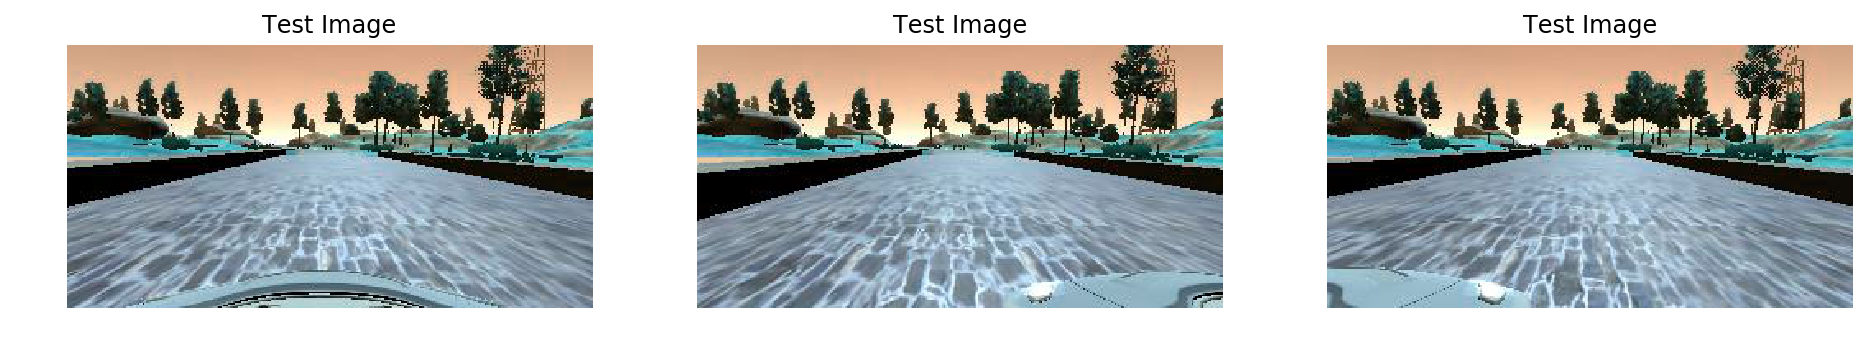

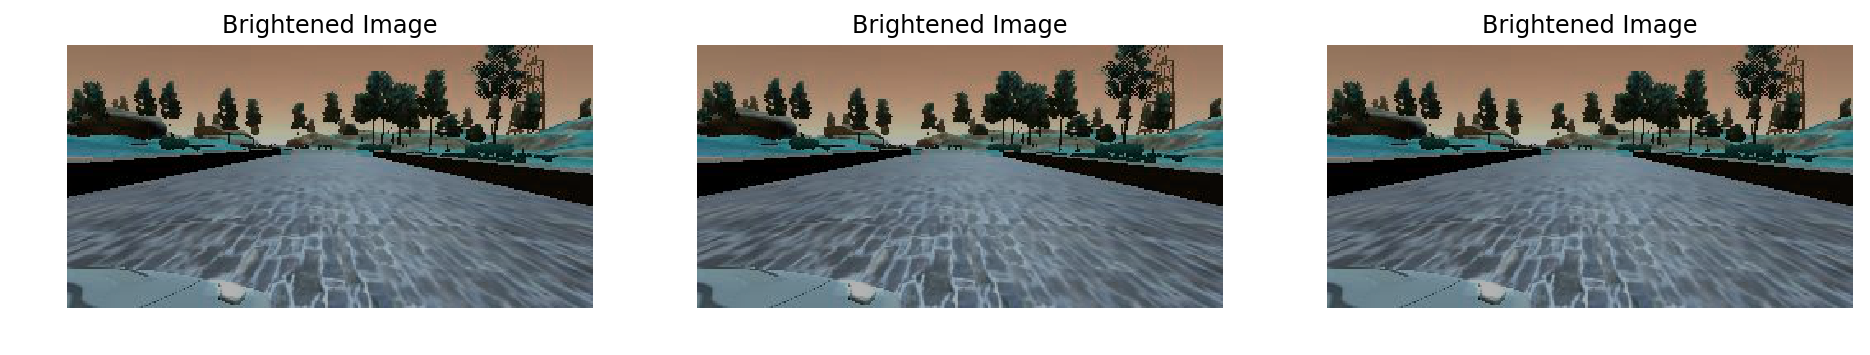

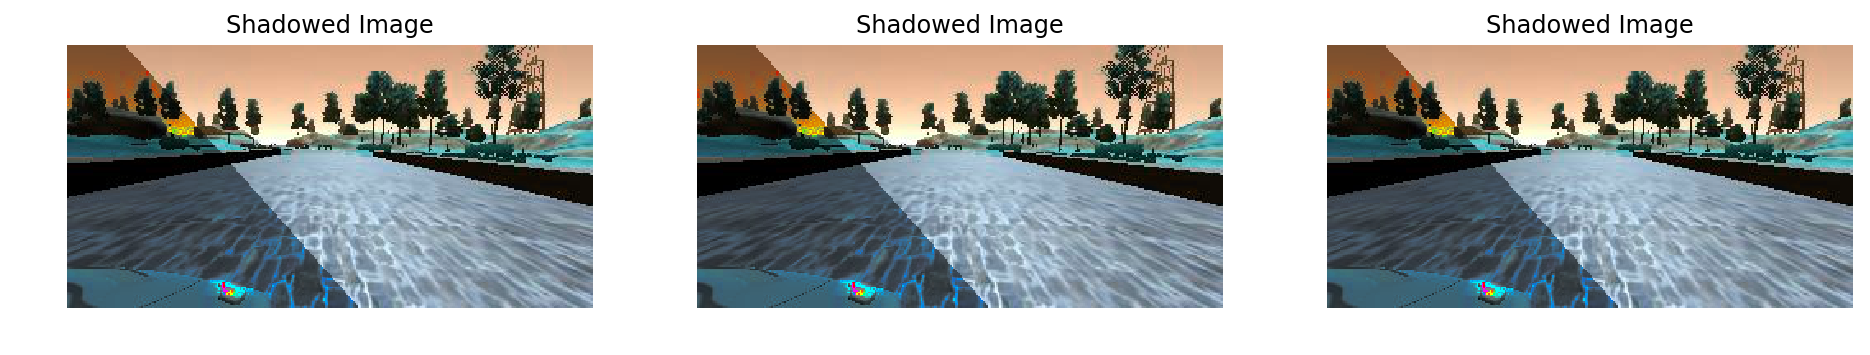

In [14]:
# Visualize data

import random
figure, axs = plt.subplots (1,3, figsize = (16,9))
figure1, axs1 = plt.subplots (1,3, figsize = (16,9))
figure2, axs2 = plt.subplots (1,3, figsize = (16,9))
axs = axs.flatten()
index = []

for i in range(3):
    index = random.randint(0, len(angles))
    test_image = cv2.imread(image_paths[i])
    brightened = brighten(test_image)
    shadowed = shadow_augmentation(test_image)
    axs[i].axis('off')
    axs[i].set_title("Test Image")
    axs[i].imshow(test_image)
for i in range(3):
    axs1[i].axis('off')
    axs1[i].set_title("Brightened Image")
    axs1[i].imshow(brightened)
for i in range(3):
    axs2[i].axis('off')
    axs2[i].set_title("Shadowed Image")
    axs2[i].imshow(shadowed)
